## File Loading

In [ ]:
# Connect this notebook to google drive (should pop up and request access)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


NOTE: Along this notebook if any libraries are not found then make a new code cell and use pip install

In [ ]:
pip install scipy numpy matplotlib umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82808 sha256=2fdd204250580669a948cd37d57687cb6c69091a8e3e77748e5b44b882fe4c06
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55617 sha256=63890fa1632c7fb8cc7701b85cd485b7a4263801d21eebaf37e8607b86779c92
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
# Import some librarys
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Iterate through files...
import os

masterSpecPre = None
masterSpecPost = None
masterSpec = None
masterStat = None

folderPathPre = '/content/drive/MyDrive/Rose_Bird/corrected_song_mat_files_14/'
folderPathPost = '/content/drive/MyDrive/Rose_Bird/corrected_song_mat_files_37/'

dayNums = [14,37,40]

def generateStackedSpec(folderPath):

  fileList = os.listdir(folderPath)
  fileList = [folderPath + s for s in fileList][0:10]
  #print(fileList)
  for filePath in fileList:
    fileData = scipy.io.loadmat(filePath)
    fileSpec = fileData['song_data']['spectrogram_data'][0][0]
    # Opt
    # fileSpec  = scipy.stats.zscore(fileSpec)

    try:
      masterSpecA = np.hstack((masterSpecA,fileSpec))

    except:
      masterSpecA = fileSpec

    #print(masterSpecA.shape)


  return masterSpecA


for day in dayNums:
    folderPath = f'/content/drive/MyDrive/Rose_Bird/corrected_song_mat_files_{day}/'
    singleSpec = generateStackedSpec(folderPath)
    singleStat = np.full((singleSpec.shape[1],),day)

    try:
      masterStat = np.hstack((masterStat,singleStat))
      masterSpec = np.hstack((masterSpec,singleSpec))
    except:
      masterStat = singleStat
      masterSpec = singleSpec

    print(masterSpec.shape)

(513, 18448)
(513, 30515)
(513, 40989)


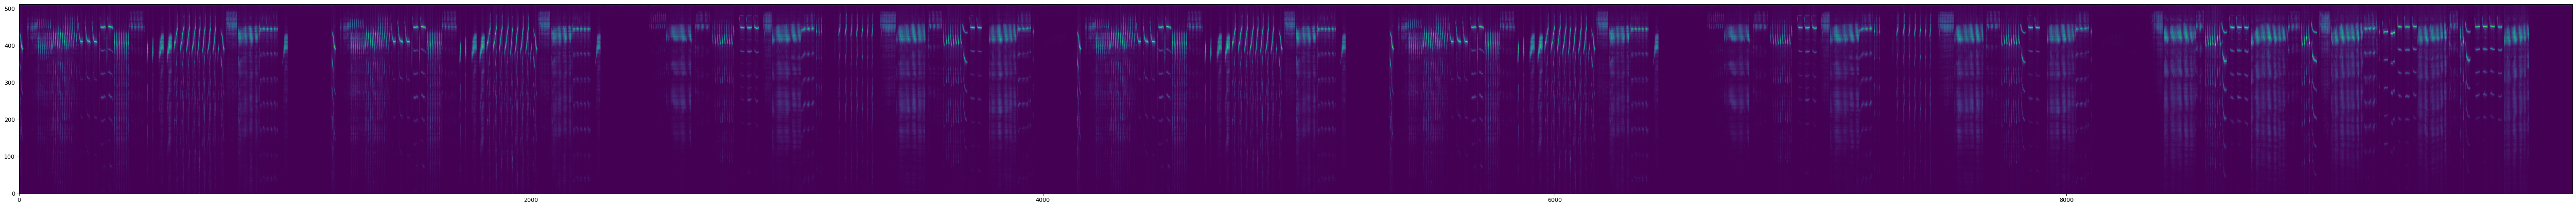

In [ ]:
plt.figure(figsize=(80, 6), dpi=80)

plt.imshow(masterSpec,origin= 'lower',aspect = 'auto')


## UMAP


In [ ]:
# To do umap we are going to take slices of this data

def get_matrix_slices(matrix, window_size, step_size,stat = []):
    matrix_shape = matrix.shape
    num_slices = (matrix_shape[1] - window_size) // step_size + 1
    slices = np.zeros((matrix_shape[0], window_size, num_slices))
    start_times = np.zeros((num_slices))

    for i in range(num_slices):
        start = i * step_size
        end = start + window_size
        slices[:, :, i] = matrix[:, start:end]
        start_times[i] = start




    return slices,start_times

window_size = 10
step_size = 1
slices, start_index = get_matrix_slices(masterSpec,window_size, step_size)
refurbished_stat = masterStat[start_index.astype(int)]
print(refurbished_stat.shape)


(40980,)


In [ ]:
print(slices.shape) # (Num Neuron, Window Size pixels, Num slices)

(513, 10, 40980)


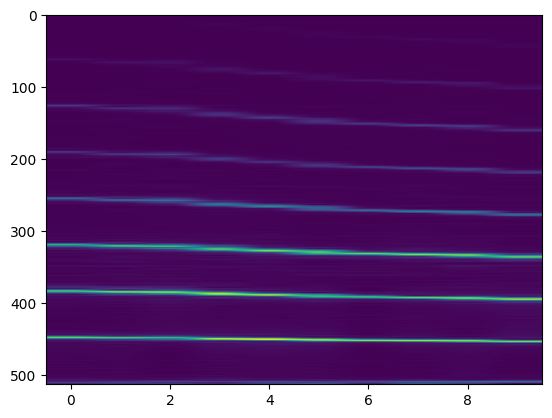

In [ ]:
# Let's plot one slice (one moment in song!)

plt.imshow(slices[:,:,230],aspect = 'auto')
plt.show()

In [ ]:
# Some algebra

# Turn each slice into a 1D vector
original_shape = slices.shape
flattened_matrix = slices.reshape(original_shape[0] * original_shape[1], original_shape[2]).T


In [ ]:
pip install umap-learn

In [ ]:
# Load the umap library, and transform the data
import umap
reducer = umap.UMAP(metric = 'euclidean')
spk_emb = reducer.fit_transform(flattened_matrix)

# Operation on day 33 7/19 (afternoon)

#38
#40

[    0     1     2 ... 18445 18446 18447]


<ipython-input-11-afbc337b6ea6>:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[0]._sizes = [30]
<ipython-input-11-afbc337b6ea6>:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[1]._sizes = [30]
<ipython-input-11-afbc337b6ea6>:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[2]._sizes = [30]


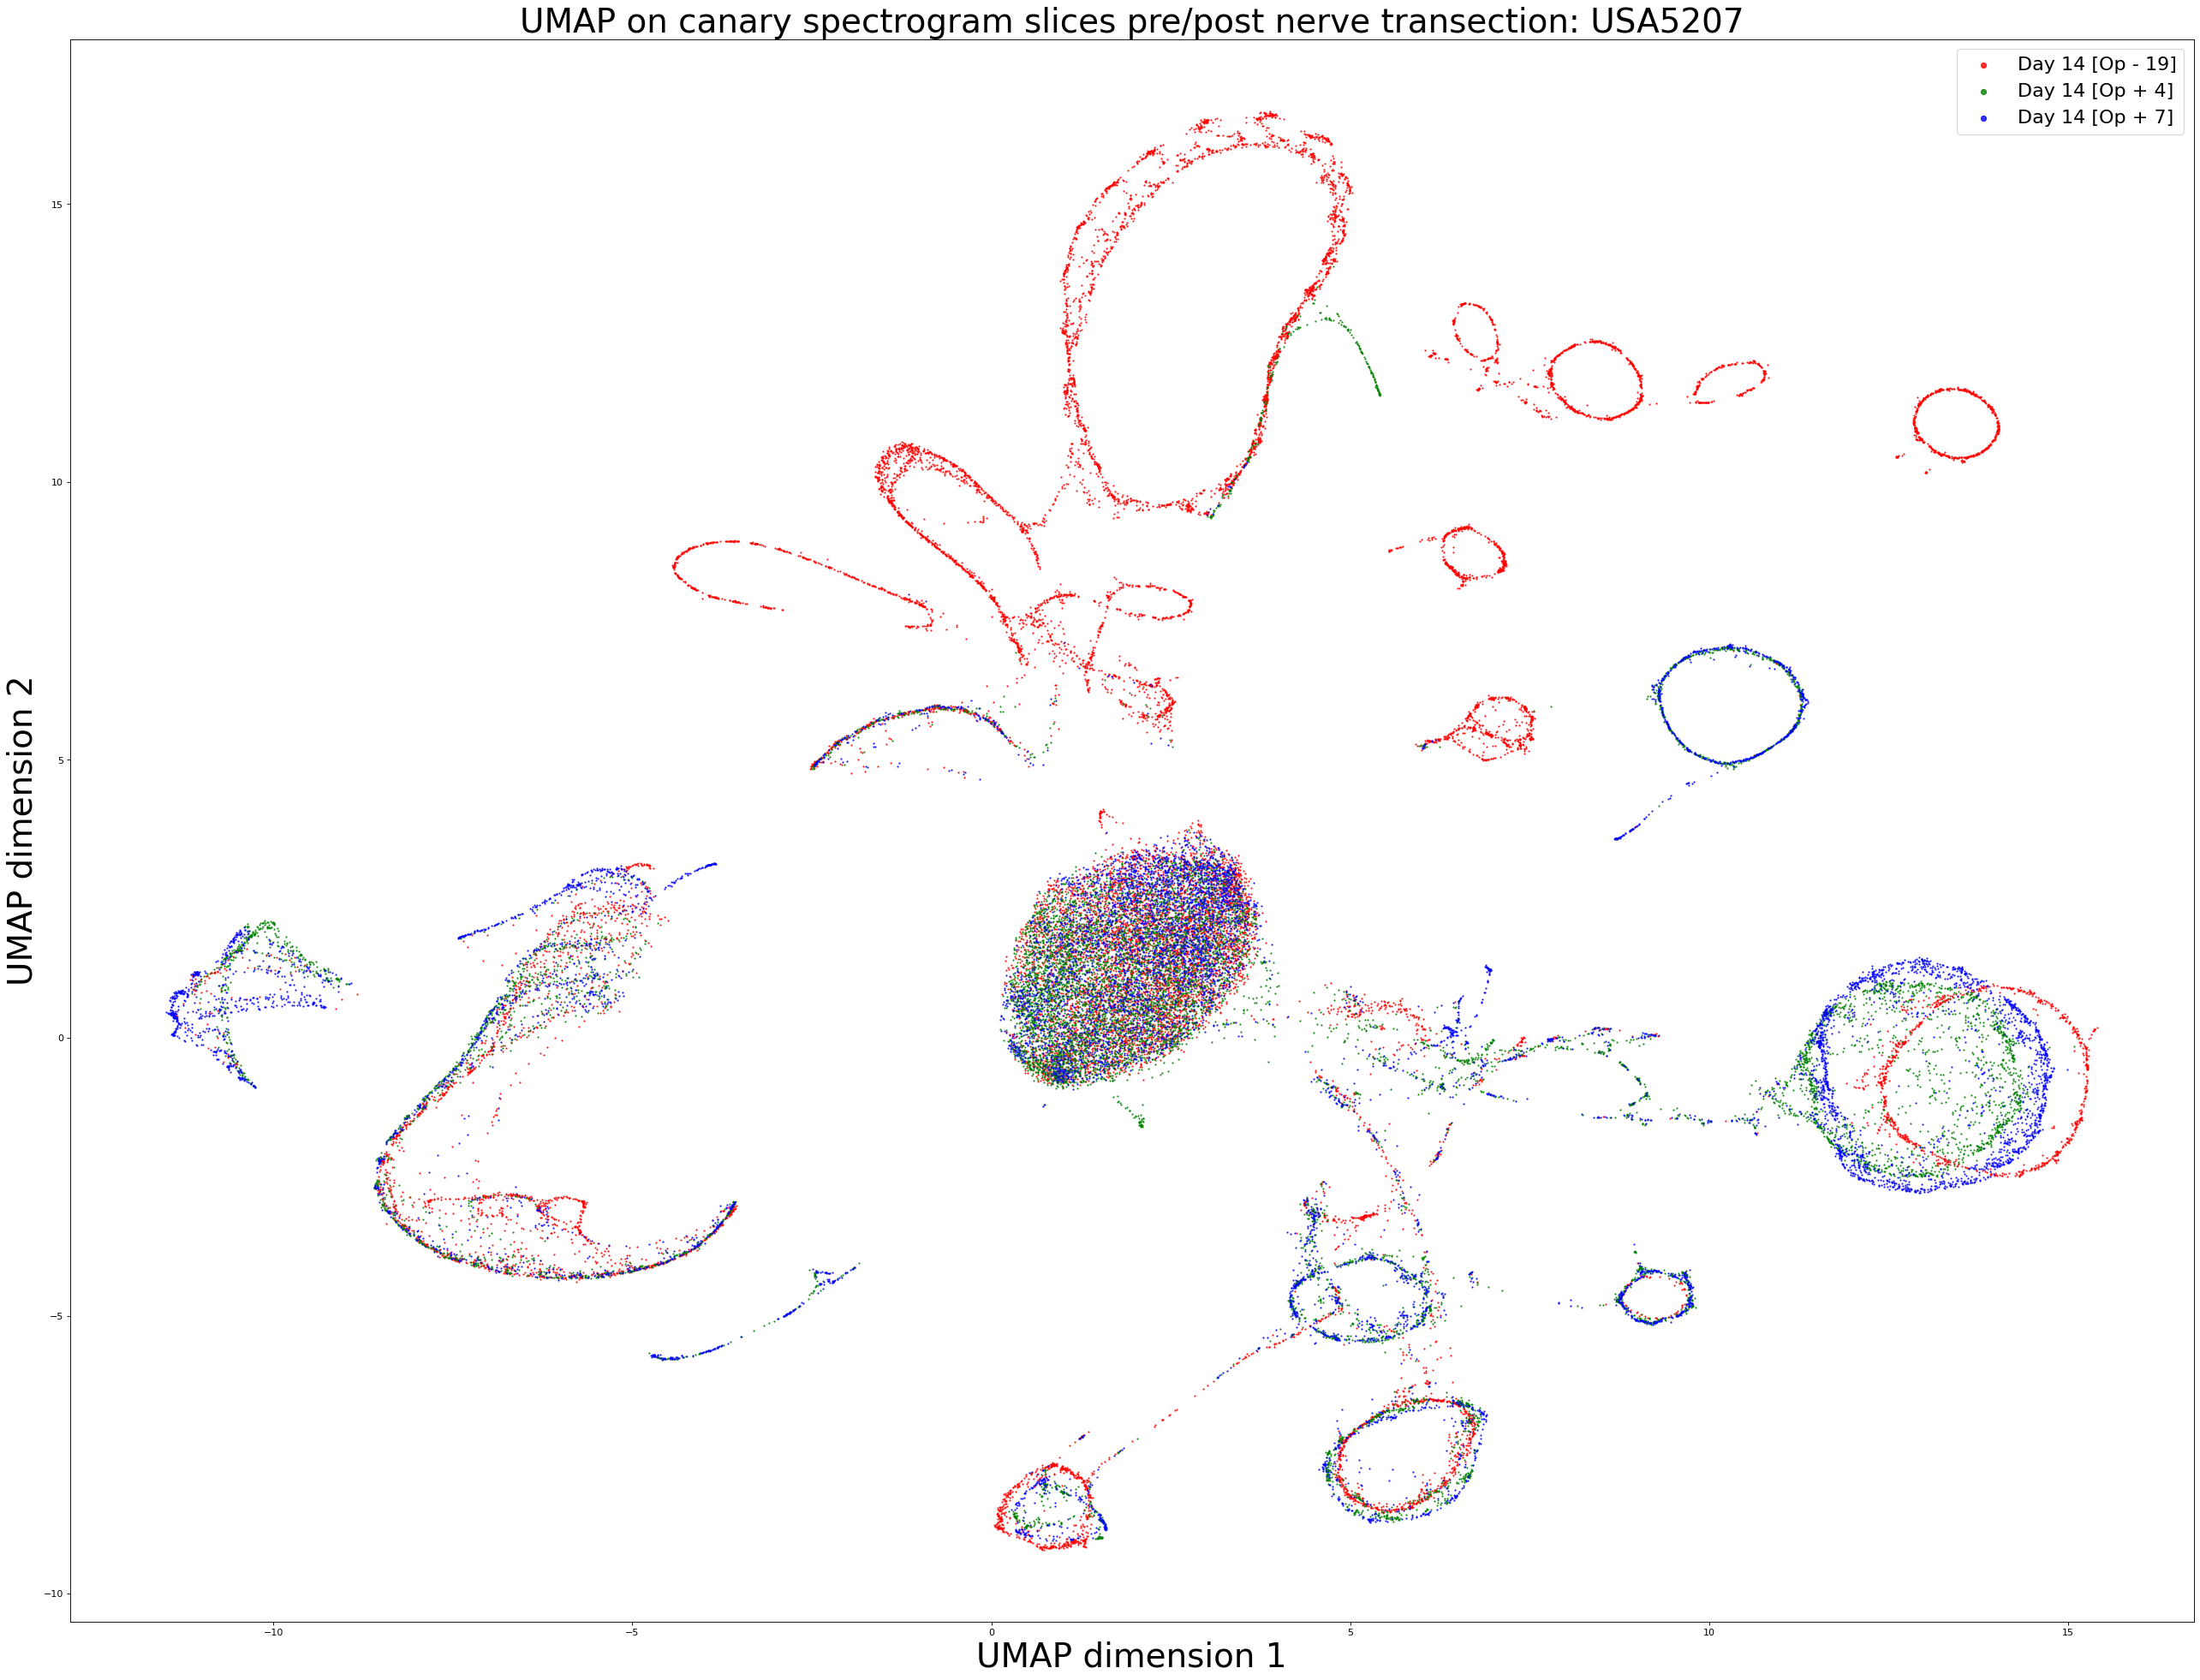

In [ ]:
numPoints = spk_emb.shape[0]
fakeTime = np.arange(numPoints)

# refurbished_stat[refurbished_stat == 40] = 2
# refurbished_stat[refurbished_stat == 37] = 1
# refurbished_stat[refurbished_stat == 14] = 0
ind14 = np.where(refurbished_stat == 14)[0]
ind37 = np.where(refurbished_stat == 37)[0]
ind40 = np.where(refurbished_stat == 40)[0]
print(ind14)

plt.figure(figsize=(40, 30), dpi=80)

plt.scatter(spk_emb[ind14,0],spk_emb[ind14,1],s = 1, color = 'red',alpha = .8,label = 'Day 14 [Op - 19]')
plt.scatter(spk_emb[ind37,0],spk_emb[ind37,1],s = 1, color = 'green',alpha = .8,label = 'Day 14 [Op + 4]')
plt.scatter(spk_emb[ind40,0],spk_emb[ind40,1],s = 1, color = 'blue',alpha = .8,label = 'Day 14 [Op + 7]')
#plt.scatter(spk_emb[:,0],spk_emb[:,1],s = 1, c=refurbished_stat, cmap = 'plasma',alpha = .8)
plt.title('UMAP on canary spectrogram slices pre/post nerve transection: USA5207',size = 35)
plt.xlabel('UMAP dimension 1',size = 35)
plt.ylabel('UMAP dimension 2',size = 35)
lgnd = plt.legend(scatterpoints=1, fontsize=20)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
# plt.colorbar()
#plt.show()#
plt.savefig('Test.png')
